# Data Processing and Feature Extraction

The objective is to organize the data to be used on the model training

Overview of the process:

1. Load al Files located on the folders by artist
2. Processs Midi files (Train and Test):
    - Extract metadata from each song
        - Generate a Feature Vector with feature extraction
        - include general information
    - Split midi file into 30-second chunks
        - Trim each chunk 
        - "Stretch" chunks that fall just short of 30 seconds 
    - Write out chunks to intermediate folders, with an iter_id for each
    - Create a DataFrame with metadata for easy access
3. Load chunks into DataFrame (Train and Test)
    - Read each chunk from disk
        - Generate information tensor using mid_acess
    - Store each midi file object in a Pandas DataFrame column

In [10]:
import os
import midi_access as midi
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd

sns.set_theme(style="whitegrid")

BASE_MIDI_DIR = './dataset/all_files/'  

In [11]:
# Load all songs by artist
artist_midi_dict = midi.load_midi_files_by_artist(BASE_MIDI_DIR)

## FEATURE EXTRACTION

Given the mid information, extract information related to the file

In [12]:
# FEATURE EXTRACTION FUNCTION
def generate_feature_vector(midi_data, top_chords):
    pitch_hist = midi.get_pitch_class_histogram(midi_data)
    ioi_hist = midi.get_ioi_histogram(midi_data)
    chord_hist = midi.get_chord_histogram(midi_data, top_chords)
    return np.concatenate([pitch_hist, ioi_hist, chord_hist])

## Processing chunks and saving

This will run through all the files and:
- generate chunks and save a chunks for later access and reference. 
For e

In [ ]:
def process_and_save_chunks_with_features(artist, song_idx, midi_data, output_dir, top_chords):
    chunks = midi.split_midi_into_chunks(midi_data)
    chunk_features = []
    for i, chunk in enumerate(chunks):
        # Generate filename and save chunk
        chunk_filename = f"{artist}_song{song_idx}_chunk{i}.mid"
        chunk_path = os.path.join(output_dir, chunk_filename)
        chunk.write(chunk_path)
        
        # Extract features for this chunk
        feature_vector = generate_feature_vector(chunk, top_chords)
        chunk_features.append({
            'artist': artist,
            'song_idx': song_idx,
            'chunk_idx': i,
            'chunk_path': chunk_path,
            'features': feature_vector
        })
    return chunk_features



> NOTICE: this will first remove the contents of intermediate_chunks folder. 

In [17]:
import shutil

all_chunk_features = []
output_dir = './dataset/intermediate_chunks'

# Clean up the output directory if it exists
if os.path.exists(output_dir):
    print(f"Removing existing output directory: {output_dir}")  
    shutil.rmtree(output_dir)

# Create the output directory
print(f"Creating output directory: {output_dir}")
os.makedirs(output_dir, exist_ok=True)
top_chords = midi.get_top_chords(artist_midi_dict, top_n=20)

# Process each artist's MIDI files and extract features
for artist, song_list in artist_midi_dict.items():
    print(f"Processing artist: {artist} with {len(song_list)} songs")
    for idx, midi_data in enumerate(song_list):
        chunk_features = process_and_save_chunks_with_features(artist, idx, midi_data, output_dir, top_chords)
        all_chunk_features.extend(chunk_features)


df_chunks = pd.DataFrame(all_chunk_features)
print(f"Total chunks processed: {len(df_chunks)}")
print(f"Saving chunk features to: {os.path.join(output_dir, './songs_by_artist_chunk_features.csv')}")

df_chunks.to_csv(os.path.join(output_dir, './songs_by_artist_chunk_features.csv'), index=False)

df_chunks.head()

Removing existing output directory: ./dataset/intermediate_chunks
Creating output directory: ./dataset/intermediate_chunks
Processing artist: mozart with 49 songs


/opt/homebrew/anaconda3/envs/masters/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges


Processing artist: chopin with 49 songs
Processing artist: handel with 49 songs
Processing artist: byrd with 50 songs
Processing artist: schumann with 44 songs
Processing artist: mendelssohn with 49 songs
Processing artist: hummel with 50 songs
Processing artist: bach with 50 songs
Processing artist: bartok with 49 songs
Total chunks processed: 4946
Saving chunk features to: ./dataset/intermediate_chunks/./songs_by_artist_chunk_features.csv


,artist,song_idx,chunk_idx,chunk_path,features
0,mozart,0,0,./dataset/intermediate_chunks/mozart_song0_chu...,"[0.08982035928143713, 0.0, 0.16467065868263472..."
1,mozart,0,1,./dataset/intermediate_chunks/mozart_song0_chu...,"[0.16722408026755853, 0.0, 0.11371237458193979..."
2,mozart,0,2,./dataset/intermediate_chunks/mozart_song0_chu...,"[0.07913669064748201, 0.0035971223021582736, 0..."
3,mozart,0,3,./dataset/intermediate_chunks/mozart_song0_chu...,"[0.12096774193548387, 0.004032258064516129, 0...."
4,mozart,0,4,./dataset/intermediate_chunks/mozart_song0_chu...,"[0.1994535519125683, 0.03278688524590164, 0.06..."


Present all 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4946 entries, 0 to 4945
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   artist      4946 non-null   object
 1   song_idx    4946 non-null   int64 
 2   chunk_idx   4946 non-null   int64 
 3   chunk_path  4946 non-null   object
 4   features    4946 non-null   object
dtypes: int64(2), object(3)
memory usage: 193.3+ KB


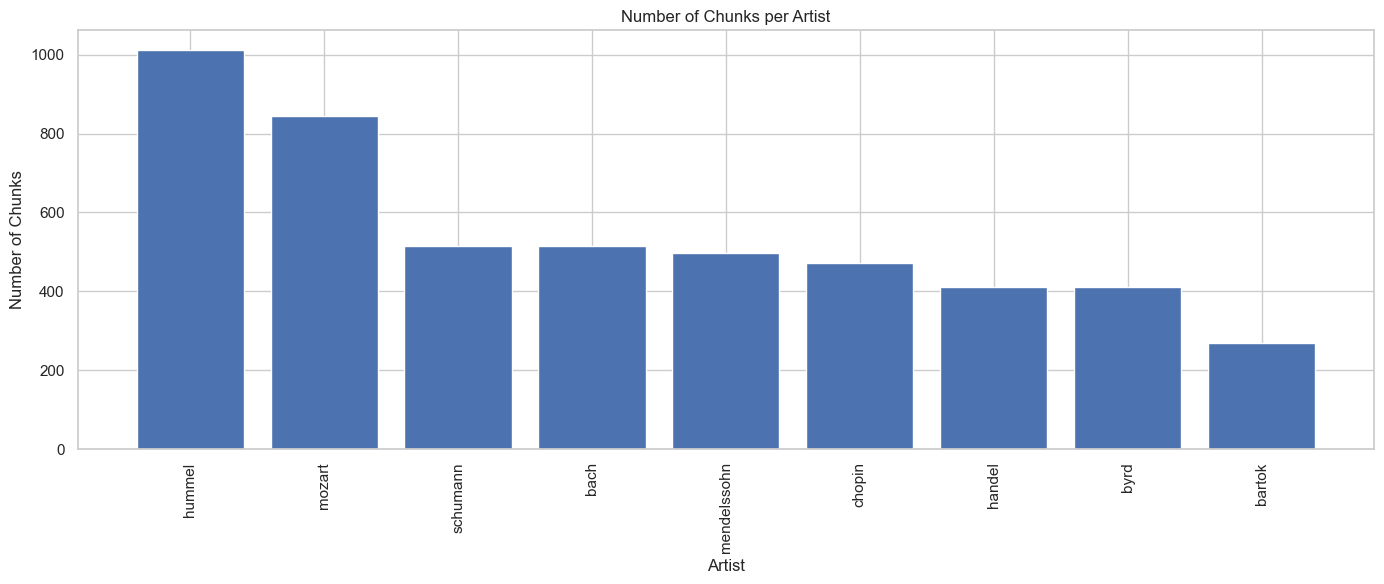

In [18]:
df_chunks.info()

chunk_counts = df_chunks['artist'].value_counts()

plt.figure(figsize=(14, 6))
plt.bar(chunk_counts.index, chunk_counts.values)
plt.xticks(rotation=90)
plt.xlabel('Artist')
plt.ylabel('Number of Chunks')
plt.title('Number of Chunks per Artist')
plt.tight_layout()
plt.show()